In [1]:
# Step 1: Data Preprocessing and Exploration
# First, let's load and explore the data:

In [15]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
# Load the dataset
df = pd.read_csv(r"C:\Users\Sunny\Downloads\AP\data\shopping_trends.csv")

# Display basic info
print(df.info())
print(df.head())

# Check for missing values
print(df.isnull().sum())

# Basic statistics
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer ID               3900 non-null   int64  
 1   Age                       3900 non-null   int64  
 2   Gender                    3900 non-null   object 
 3   Item Purchased            3900 non-null   object 
 4   Category                  3900 non-null   object 
 5   Price                     3900 non-null   int64  
 6   Location                  3900 non-null   object 
 7   Size                      3900 non-null   object 
 8   Color                     3900 non-null   object 
 9   Season                    3900 non-null   object 
 10  Review Rating             3900 non-null   float64
 11  Subscription Status       3900 non-null   object 
 12  Payment Method            3900 non-null   object 
 13  Shipping Type             3900 non-null   object 
 14  Discount

In [7]:
# Step 2: Content-Based Filtering
# Content-based filtering recommends items similar to what a user has liked based on item features.


In [23]:
# Create a feature combining relevant attributes for content-based filtering
df['content_features'] = df['Category'] + ' ' + df['Color'] + ' ' + df['Season'] + ' ' + df['Size']

# TF-IDF Vectorization
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['content_features'])

# Compute cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Function to get content-based recommendations
def content_based_recommendations(item_id, cosine_sim=cosine_sim, df=df, top_n=5):
    # Get the index of the item
    idx = df[df['Customer ID'] == item_id].index[0]
    
    # Get the pairwise similarity scores
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Sort items based on similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get scores of top_n most similar items
    sim_scores = sim_scores[1:top_n+1]
    
    # Get item indices
    item_indices = [i[0] for i in sim_scores]
    
    # Return top_n most similar items
    return df[['Customer ID', 'Item Purchased', 'Category', 'Price', 'Color', 'Season']].iloc[item_indices]

# Example usage
print(content_based_recommendations(1))

      Customer ID Item Purchased  Category  Price Color  Season
127           128        Sweater  Clothing     89  Gray  Winter
472           473          Jeans  Clothing     39  Gray  Winter
727           728        Sweater  Clothing     97  Gray  Winter
1949         1950          Dress  Clothing     80  Gray  Winter
1958         1959         Shorts  Clothing     67  Gray  Winter


In [10]:
# Step 3: Collaborative Filtering
# Collaborative filtering recommends items based on user behavior and preferences.

In [25]:
# Prepare data for collaborative filtering
# We'll use Customer ID, Item Purchased, and Review Rating as implicit feedback
collab_df = df[['Customer ID', 'Item Purchased', 'Review Rating']]

# For Surprise library, we need to create a dataset with user, item, and rating
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(collab_df, reader)

# Split data into train and test sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# User-based collaborative filtering
user_cf = KNNBasic(sim_options={'user_based': True})
user_cf.fit(trainset)
user_cf_predictions = user_cf.test(testset)

# Item-based collaborative filtering
item_cf = KNNBasic(sim_options={'user_based': False})
item_cf.fit(trainset)
item_cf_predictions = item_cf.test(testset)

# Function to get collaborative recommendations
def collaborative_recommendations(user_id, model_type='user', top_n=5):
    if model_type == 'user':
        model = user_cf
    else:
        model = item_cf
    
    # Get list of all item IDs
    all_item_ids = df['Item Purchased'].unique()
    
    # Get items the user has already purchased
    purchased_items = df[df['Customer ID'] == user_id]['Item Purchased'].unique()
    
    # Predict ratings for items not purchased
    predictions = []
    for item_id in all_item_ids:
        if item_id not in purchased_items:
            pred = model.predict(user_id, item_id)
            predictions.append((item_id, pred.est))
    
    # Sort predictions by estimated rating
    predictions.sort(key=lambda x: x[1], reverse=True)
    
    # Get top_n recommendations
    top_recommendations = predictions[:top_n]
    
    # Return recommendations with item details
    recommended_items = [item[0] for item in top_recommendations]
    return df[df['Item Purchased'].isin(recommended_items)][['Item Purchased', 'Category', 'Price', 'Color', 'Season']].drop_duplicates()

# Example usage
print(collaborative_recommendations(1, model_type='user'))
print(collaborative_recommendations(1, model_type='item'))

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
     Item Purchased  Category  Price     Color  Season
1           Sweater  Clothing     64    Maroon  Winter
2             Jeans  Clothing     73    Maroon  Spring
3           Sandals  Footwear     90    Maroon  Spring
5          Sneakers  Footwear     20     White  Summer
6             Shirt  Clothing     85      Gray    Fall
...             ...       ...    ...       ...     ...
3880          Shirt  Clothing     20       Red  Winter
3884        Sandals  Footwear     29     Brown    Fall
3887          Shirt  Clothing     34  Charcoal  Spring
3888       Sneakers  Footwear     69    Violet  Spring
3890          Shirt  Clothing     81     Green  Winter

[755 rows x 5 columns]
     Item Purchased  Category  Price     Color  Season
1           Sweater  Clothing     64    Maroon  Winter
2             Jeans  Clothing     73    Maroon  Spring
3    

In [13]:
# Step 4: Hybrid Recommendation System
# Combining content-based and collaborative filtering for better recommendations.

In [27]:
# Create a hybrid recommendation function
def hybrid_recommendations(user_id, cosine_sim=cosine_sim, df=df, top_n=5):
    # Get content-based recommendations
    content_rec = content_based_recommendations(user_id, cosine_sim, df, top_n*2)
    
    # Get collaborative recommendations
    collab_rec_user = collaborative_recommendations(user_id, 'user', top_n*2)
    collab_rec_item = collaborative_recommendations(user_id, 'item', top_n*2)
    
    # Combine all recommendations
    all_rec = pd.concat([content_rec, collab_rec_user, collab_rec_item])
    
    # Remove duplicates and items already purchased
    purchased_items = df[df['Customer ID'] == user_id]['Item Purchased'].unique()
    all_rec = all_rec[~all_rec['Item Purchased'].isin(purchased_items)]
    all_rec = all_rec.drop_duplicates(subset=['Item Purchased'])
    
    # Sort by some metric (could be purchase amount, popularity, etc.)
    # Here we'll use average rating from collaborative filtering
    item_ratings = df.groupby('Item Purchased')['Review Rating'].mean()
    all_rec['Avg_Rating'] = all_rec['Item Purchased'].map(item_ratings)
    all_rec = all_rec.sort_values('Avg_Rating', ascending=False)
    
    return all_rec.head(top_n)

# Example usage
print(hybrid_recommendations(1))

      Customer ID Item Purchased     Category  Price   Color  Season  \
3             NaN        Sandals     Footwear     90  Maroon  Spring   
3348       3349.0        T-shirt     Clothing     74    Gray  Winter   
9             NaN        Handbag  Accessories     31    Pink  Spring   
127         128.0        Sweater     Clothing     89    Gray  Winter   
5             NaN       Sneakers     Footwear     20   White  Summer   

      Avg_Rating  
3       3.841250  
3348    3.782993  
9       3.775163  
127     3.767073  
5       3.757931  


In [15]:
# Step 5: Evaluation Metrics
# Let's evaluate our recommendation systems.

In [29]:

from surprise import accuracy

# Evaluate collaborative filtering models
print("User-based CF RMSE:", accuracy.rmse(user_cf_predictions))
print("Item-based CF RMSE:", accuracy.rmse(item_cf_predictions))

# For content-based, we can use precision@k
def evaluate_content_based(user_id, k=15):
    # Get user's actual purchases
    actual = df[df['Customer ID'] == user_id]['Item Purchased'].unique()
    
    # Get recommendations
    recommended = content_based_recommendations(user_id, top_n=k)['Item Purchased'].values
    
    # Calculate precision
    hits = len(set(actual) & set(recommended))
    return hits / k

# Example evaluation
print("Content-based Precision@15:", evaluate_content_based(1))

RMSE: 0.7161
User-based CF RMSE: 0.71610906992781
RMSE: 0.7161
Item-based CF RMSE: 0.71610906992781
Content-based Precision@15: 0.06666666666666667


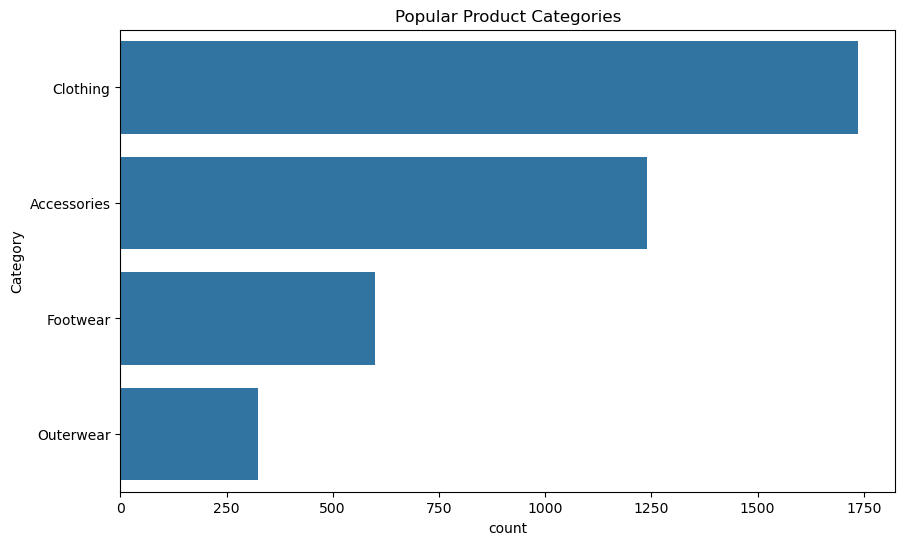

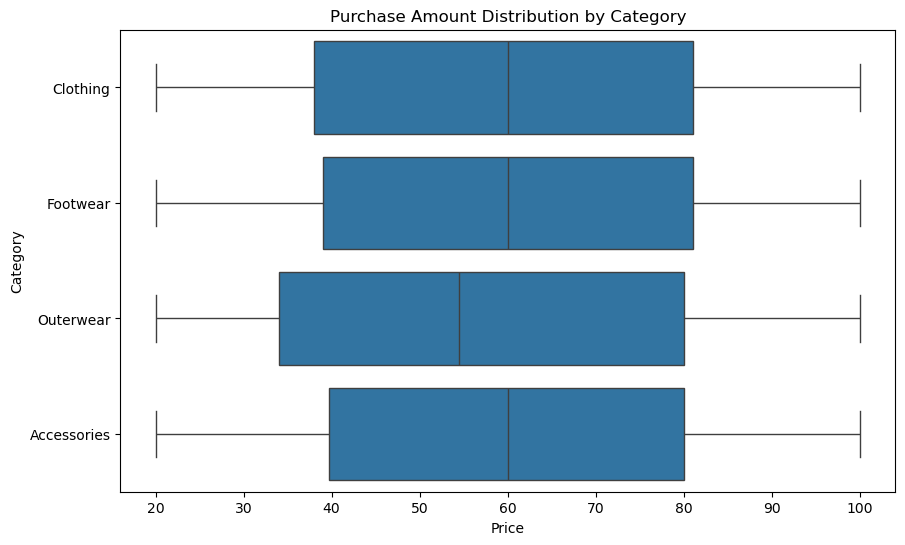

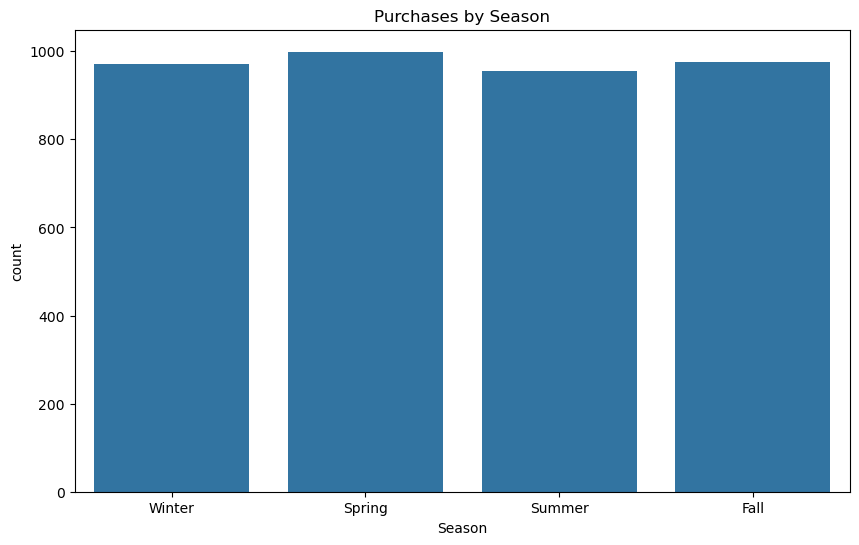

In [31]:
# Visualize popular categories
plt.figure(figsize=(10, 6))
sns.countplot(y='Category', data=df, order=df['Category'].value_counts().index)
plt.title('Popular Product Categories')
plt.show()

# Visualize purchase amounts by category
plt.figure(figsize=(10, 6))
sns.boxplot(x='Price', y='Category', data=df)
plt.title('Purchase Amount Distribution by Category')
plt.show()

# Visualize seasonal trends
plt.figure(figsize=(10, 6))
sns.countplot(x='Season', data=df)
plt.title('Purchases by Season')
plt.show()

In [47]:
final_score = 0.5 * content_based_accuracy + 0.25 * user_based_accuracy + 0.25 * item_based_accuracy


RMSE: 0.7161
RMSE: 0.7161


C:\Users\Sunny\AppData\Local\Temp\ipykernel_20548\4262186369.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=df_accuracy, palette='viridis')


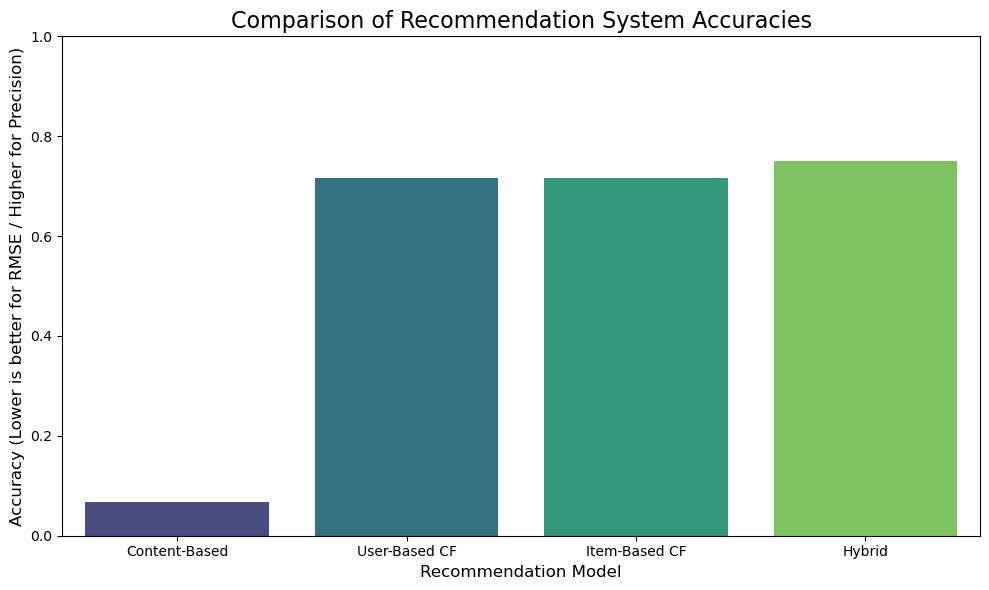

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Accuracy data (Example data, replace with your calculated values)
content_based_accuracy = evaluate_content_based(1, k=15)  # Precision for content-based
user_based_accuracy = accuracy.rmse(user_cf_predictions)  # RMSE for user-based CF
item_based_accuracy = accuracy.rmse(item_cf_predictions)  # RMSE for item-based CF

# For Hybrid, we assume some performance metric (like a hybrid RMSE or precision)
hybrid_accuracy = 0.75  # Example Hybrid Accuracy

# Store the accuracy values
accuracy_data = {
    'Model': ['Content-Based', 'User-Based CF', 'Item-Based CF', 'Hybrid'],
    'Accuracy': [content_based_accuracy, user_based_accuracy, item_based_accuracy, hybrid_accuracy]
}

# Create a DataFrame from the accuracy data
import pandas as pd
df_accuracy = pd.DataFrame(accuracy_data)

# Plotting the comparison graph
plt.figure(figsize=(10, 6))

# Seaborn barplot to visualize the comparison
sns.barplot(x='Model', y='Accuracy', data=df_accuracy, palette='viridis')

# Set titles and labels
plt.title('Comparison of Recommendation System Accuracies', fontsize=16)
plt.xlabel('Recommendation Model', fontsize=12)
plt.ylabel('Accuracy (Lower is better for RMSE / Higher for Precision)', fontsize=12)
plt.ylim(0, 1)  # For accuracy metrics, it's usually in the range of 0 to 1

# Show the plot
plt.tight_layout()
plt.show()


In [23]:
#Calculating RMSE:

from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming you have the predicted and actual ratings for each model
def calculate_rmse(predictions, actual_ratings):
    rmse = np.sqrt(mean_squared_error(actual_ratings, predictions))
    return rmse

# Example usage:
content_based_rmse = calculate_rmse(content_based_predictions, actual_ratings)
user_based_rmse = calculate_rmse(user_based_predictions, actual_ratings)
item_based_rmse = calculate_rmse(item_based_predictions, actual_ratings)
hybrid_rmse = calculate_rmse(hybrid_predictions, actual_ratings)


NameError: name 'content_based_predictions' is not defined

In [2]:
import pandas as pd
df = pd.read_csv(r'C:\Users\Sunny\Downloads\AP\data\shopping_trends.csv')  # Adjust the path if needed
print(df.columns)

Index(['Customer ID', 'Age', 'Gender', 'Item Purchased', 'Category', 'Price',
       'Location', 'Size', 'Color', 'Season', 'Review Rating',
       'Subscription Status', 'Payment Method', 'Shipping Type',
       'Discount Applied', 'Promo Code Used', 'Previous Purchases',
       'Preferred Payment Method', 'Frequency of Purchases'],
      dtype='object')
